<a href="https://colab.research.google.com/github/Alan-Cheong/IEEE_QW_2020/blob/master/Superconductivity_Electron_Phonon_Interaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

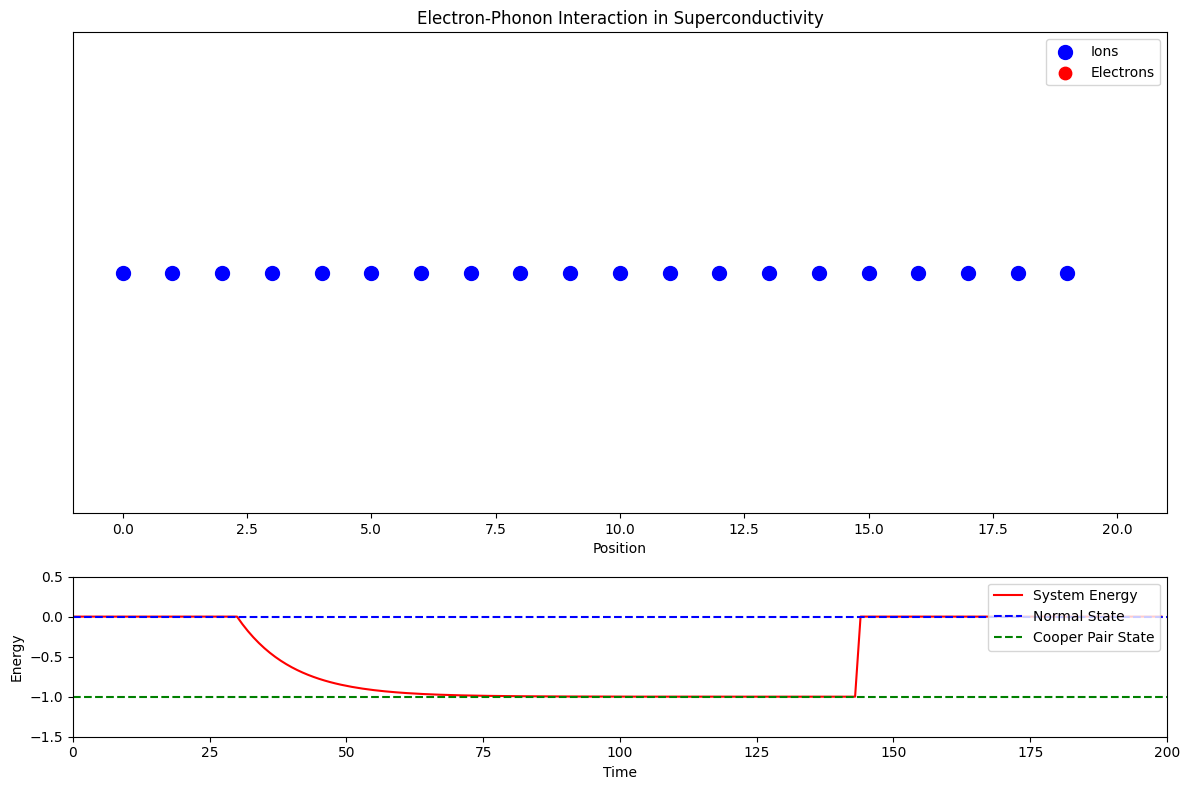

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.gridspec import GridSpec
from matplotlib.colors import to_rgba
from IPython.display import HTML # Import necessary module

class SuperconductivityAnimation:
    def __init__(self):
        # Simulation parameters
        self.num_ions = 20
        self.num_electrons = 2
        self.lattice_spacing = 1.0
        self.fig_size = (12, 8)
        self.animation_frames = 200
        self.delay_between_electrons = 20  # Frames between first and second electron

        # Physics parameters
        self.electron_velocity = 0.15
        self.distortion_strength = 0.2
        self.distortion_range = 3.0
        self.distortion_decay = 0.1
        self.attraction_strength = 0.05

        # Initialize positions
        self.ion_positions = np.array([
            [i * self.lattice_spacing, 0] for i in range(self.num_ions)
        ])
        self.ion_displacements = np.zeros((self.num_ions, 2))

        # Electron trajectories
        self.electron_positions = np.zeros((self.animation_frames, self.num_electrons, 2))
        self.electron_positions[:, :, 0] = -1  # Initialize off-screen
        self.electron_positions[:, :, 1] = self.lattice_spacing / 2

        # Interaction visualization
        self.interaction_strength = np.zeros((self.animation_frames, self.num_ions))

        # Setup figure and axes
        self.setup_figure()

    def setup_figure(self):
        """Set up the figure and axes for the animation"""
        self.fig = plt.figure(figsize=self.fig_size)
        gs = GridSpec(2, 1, height_ratios=[3, 1])

        # Lattice visualization
        self.ax_lattice = self.fig.add_subplot(gs[0])
        self.ax_lattice.set_xlim(-1, (self.num_ions + 1) * self.lattice_spacing)
        self.ax_lattice.set_ylim(-1, 1)
        self.ax_lattice.set_title("Electron-Phonon Interaction in Superconductivity")
        self.ax_lattice.set_xlabel("Position")
        self.ax_lattice.set_yticks([])

        # Energy level diagram
        self.ax_energy = self.fig.add_subplot(gs[1])
        self.ax_energy.set_xlim(0, self.animation_frames)
        self.ax_energy.set_ylim(-1.5, 0.5)
        self.ax_energy.set_ylabel("Energy")
        self.ax_energy.set_xlabel("Time")

        # Create artists for animation
        self.ion_scatter = self.ax_lattice.scatter(
            self.ion_positions[:, 0],
            self.ion_positions[:, 1],
            s=100, color='blue', label="Ions"
        )

        self.electron_scatter = self.ax_lattice.scatter(
            [], [], s=80, color='red', label="Electrons"
        )

        self.distortion_lines = []
        for i in range(self.num_ions):
            line, = self.ax_lattice.plot([], [], 'g-', alpha=0.3)
            self.distortion_lines.append(line)

        # For energy plot
        self.energy_line, = self.ax_energy.plot([], [], 'r-', label="System Energy")
        self.normal_energy = self.ax_energy.axhline(y=0, color='blue', linestyle='--', label="Normal State")
        self.paired_energy = self.ax_energy.axhline(y=-1, color='green', linestyle='--', label="Cooper Pair State")

        # Add annotation for Cooper pair
        self.cooper_pair_text = self.ax_lattice.text(
            self.num_ions * self.lattice_spacing / 2,
            0.8,
            "Cooper Pair Formation",
            ha='center',
            fontsize=12,
            bbox=dict(facecolor='white', alpha=0.7),
            visible=False
        )

        self.ax_lattice.legend(loc='upper right')
        self.ax_energy.legend(loc='upper right')
        self.fig.tight_layout()

    def simulate(self):
        """Run the simulation of electron movement and lattice distortion"""
        # First electron enters after some delay
        start_frame_e1 = 10

        # Calculate first electron positions
        for frame in range(start_frame_e1, self.animation_frames):
            pos = (frame - start_frame_e1) * self.electron_velocity
            if pos <= self.num_ions * self.lattice_spacing:
                self.electron_positions[frame, 0, 0] = pos

        # Second electron enters after first one
        start_frame_e2 = start_frame_e1 + self.delay_between_electrons

        # Calculate second electron positions (following the first with attraction)
        prev_pos = self.electron_positions[start_frame_e2, 0, 0]
        self.electron_positions[start_frame_e2, 1, 0] = 0

        for frame in range(start_frame_e2 + 1, self.animation_frames):
            # Normal movement
            pos = (frame - start_frame_e2) * self.electron_velocity

            # Add attraction to the first electron (Cooper pair formation)
            if frame > start_frame_e2 + 50:  # Start attraction after some time
                e1_pos = self.electron_positions[frame, 0, 0]
                distance = e1_pos - prev_pos
                attraction = self.attraction_strength * distance
                pos += attraction

            if pos <= self.num_ions * self.lattice_spacing:
                self.electron_positions[frame, 1, 0] = pos
            prev_pos = pos

        # Calculate lattice distortion for each frame
        for frame in range(self.animation_frames):
            # Reset displacements
            self.ion_displacements.fill(0)

            # For each electron that's on screen, calculate its effect on the lattice
            for e in range(self.num_electrons):
                e_pos = self.electron_positions[frame, e, 0]
                if e_pos > 0:
                    for i in range(self.num_ions):
                        ion_pos = self.ion_positions[i, 0]
                        distance = abs(e_pos - ion_pos)

                        # Apply distortion within range
                        if distance < self.distortion_range:
                            # Vertical displacement (attraction towards electron)
                            displacement = self.distortion_strength * np.exp(-distance * self.distortion_decay)
                            direction = -1 if e_pos > ion_pos else 1  # Direction of displacement
                            self.ion_displacements[i, 1] += displacement * direction

                            # Record interaction strength for visualization
                            self.interaction_strength[frame, i] = displacement

        # Calculate system energy
        energy = np.zeros(self.animation_frames)
        for frame in range(self.animation_frames):
            # Base energy is zero (normal state)
            energy[frame] = 0

            # If both electrons are present, calculate pair binding energy
            if (self.electron_positions[frame, 0, 0] > 0 and
                self.electron_positions[frame, 1, 0] > 0):

                distance = abs(self.electron_positions[frame, 0, 0] -
                               self.electron_positions[frame, 1, 0])

                # Cooper pairing lowers energy if electrons are close enough
                if distance < 5 * self.lattice_spacing:
                    # Energy gradually decreases to -1 as electrons get closer
                    energy[frame] = -1 * (1 - np.exp(-0.1 * (frame - start_frame_e2)))

        return energy

    def init_animation(self):
        """Initialize animation"""
        self.electron_scatter.set_offsets(np.zeros((0, 2)))
        for line in self.distortion_lines:
            line.set_data([], [])
        self.energy_line.set_data([], [])
        return [self.electron_scatter, *self.distortion_lines, self.energy_line, self.cooper_pair_text]

    def animate(self, frame):
        """Update animation for each frame"""
        # Update ion positions with calculated displacements
        displaced_positions = self.ion_positions + self.ion_displacements
        self.ion_scatter.set_offsets(displaced_positions)

        # Update electron positions (only show ones that are on screen)
        visible_electrons = []
        for e in range(self.num_electrons):
            if 0 <= self.electron_positions[frame, e, 0] <= self.num_ions * self.lattice_spacing:
                visible_electrons.append(self.electron_positions[frame, e])

        if visible_electrons:
            self.electron_scatter.set_offsets(visible_electrons)
        else:
            self.electron_scatter.set_offsets(np.zeros((0, 2)))

        # Update distortion visualization
        for i in range(self.num_ions):
            x = self.ion_positions[i, 0]
            y = self.ion_positions[i, 1] + self.ion_displacements[i, 1]
            self.distortion_lines[i].set_data([x, x], [0, y])

            # Change line color intensity based on distortion
            intensity = min(1.0, abs(self.ion_displacements[i, 1]) * 5)
            color = to_rgba('green', alpha=intensity * 0.8)
            self.distortion_lines[i].set_color(color)

        # Update energy plot
        self.energy_line.set_data(range(frame+1), self.energy[:frame+1])

        # Show Cooper pair text when both electrons are visible and close
        both_visible = (0 < self.electron_positions[frame, 0, 0] <= self.num_ions * self.lattice_spacing and
                        0 < self.electron_positions[frame, 1, 0] <= self.num_ions * self.lattice_spacing)

        if both_visible:
            distance = abs(self.electron_positions[frame, 0, 0] - self.electron_positions[frame, 1, 0])
            if distance < 4 * self.lattice_spacing and frame > 100:
                self.cooper_pair_text.set_visible(True)
                # Position text between electrons
                mid_x = (self.electron_positions[frame, 0, 0] + self.electron_positions[frame, 1, 0]) / 2
                self.cooper_pair_text.set_position((mid_x, 0.8))
            else:
                self.cooper_pair_text.set_visible(False)
        else:
            self.cooper_pair_text.set_visible(False)

        return [self.ion_scatter, self.electron_scatter, *self.distortion_lines,
                self.energy_line, self.cooper_pair_text]

    def create_animation(self):
        """Create and return the animation"""
        energy = self.simulate()
        self.energy = energy

        ani = animation.FuncAnimation(
            self.fig,
            self.animate,
            frames=self.animation_frames,
            init_func=self.init_animation,
            blit=True,
            interval=50
        )

        return ani

def run_animation():
    """Run the superconductivity animation"""
    sim = SuperconductivityAnimation()
    ani = sim.create_animation()
   # Instead of plt.show(), display the animation as HTML5 video
    display(HTML(ani.to_html5_video()))
    # To save as a video file (optional)
    # ani.save('superconductivity.mp4', writer='ffmpeg', fps=20)

    #plt.show()

if __name__ == "__main__":
    run_animation()


